In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
import time
import torchvision
from statistics import mean
import copy
import pandas as pd
from torch.utils.data import Sampler
import random

In [ ]:
image_size = 224
directory='drive/MyDrive/Flower_Recognition'
    
training_set = torchvision.datasets.Flowers102(root=f'{directory}', transform=transforms.Compose(
        [   
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),split='train')
validation_set = torchvision.datasets.Flowers102(root=f'{directory}', transform=transforms.Compose(
        [
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ), split='val')
test_set = torchvision.datasets.Flowers102(root=f'{directory}', transform=transforms.Compose(
        [
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ), split='test')
    
print(f'Length of training data: {len(training_set)}')
print(f'Length of validation data: {len(validation_set)}')
print(f'Length of test data: {len(test_set)}')

Length of training data: 1020
Length of validation data: 1020
Length of test data: 6149


In [ ]:
class RelationNetwork(nn.Module):
    def __init__(self, distance_metric_module: nn.Module, encoder: nn.Module):
        super(RelationNetwork, self).__init__()

        #finding backbone shape
        input_imgs = torch.ones((1, 3, 224, 224))
        output = copy.deepcopy(encoder).cpu()(input_imgs)
        self.encoder_output_shape = tuple(output.shape[1:])

        self.distance_metric_module = distance_metric_module
        self.encoder = encoder

    def forward(self, support_images: torch.Tensor,support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        
        support_feature_maps = self.encoder.forward(support_images)
        query_feature_maps = self.encoder.forward(query_images)
        
        n_way = len(torch.unique(support_labels))
        support_class_prototypes = torch.cat(
            [
                support_feature_maps[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        query_prototype_concatenated_pairs = torch.cat(
            (
                support_class_prototypes.unsqueeze(dim=0).expand(
                    query_feature_maps.shape[0], -1, -1, -1, -1
                ),
                query_feature_maps.unsqueeze(dim=1).expand(
                    -1, support_class_prototypes.shape[0], -1, -1, -1
                ),
            ),
            dim=2,
        ).view(-1, 2 * self.encoder_output_shape[0], *query_feature_maps.shape[2:])

        relation_scores = self.distance_metric_module(query_prototype_concatenated_pairs).view(
            -1, support_class_prototypes.shape[0]
        )

        return relation_scores

In [ ]:
convolutional_network_backbone = resnet18(pretrained=True
                                          )
convolutional_network_backbone = torch.nn.Sequential(*(list(convolutional_network_backbone.children())[:-2]))
print(convolutional_network_backbone)

input_imgs = torch.ones((1, 3, 224, 224))
output = copy.deepcopy(convolutional_network_backbone).cpu()(input_imgs)
encoder_output_shape = tuple(output.shape[1:])
print(encoder_output_shape)

distance_metric_module_network = nn.Sequential(
        nn.Sequential(
            nn.Conv2d(
                encoder_output_shape[0] * 2,
                encoder_output_shape[0],
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(encoder_output_shape[0], momentum=1, affine=True),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((5, 5)),
        ),
        nn.Sequential(
            nn.Conv2d(
                encoder_output_shape[0],
                encoder_output_shape[0],
                kernel_size=3,
                padding=0,
            ),
            nn.BatchNorm2d(encoder_output_shape[0], momentum=1, affine=True),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((1, 1)),
        ),
        nn.Flatten(),
        nn.Linear(encoder_output_shape[0], 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid(),
    )


model = RelationNetwork(distance_metric_module_network, convolutional_network_backbone).cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
n_way = 5
k_shot = 4
n_query = 6
n_tasks = 100
n_train_tasks = 100
n_val_tasks = 100
n_test_tasks = 1000

In [ ]:
from scipy.io import loadmat
labels = loadmat('drive/MyDrive/Flower_Recognition/flowers-102/imagelabels.mat',squeeze_me=True)
setids = loadmat('drive/MyDrive/Flower_Recognition/flowers-102/setid.mat',squeeze_me=True)
image_id_to_label = dict(enumerate((labels["labels"] - 1).tolist(), 1))
train_ids = setids['trnid']
val_ids = setids['valid']
test_ids = setids['tstid']

In [ ]:
training_set.get_labels = lambda: [
    image_id_to_label[id] for id in train_ids
]

validation_set.get_labels = lambda: [
    image_id_to_label[id] for id in val_ids
]

test_set.get_labels = lambda: [
    image_id_to_label[id] for id in test_ids
]

In [ ]:
class TaskSampler(Sampler):
    
    def __init__(self, dataset, n_way, k_shot, n_query, n_tasks):
        super().__init__(data_source=None)
        self.n_way = n_way
        self.k_shot = k_shot
        self.n_tasks = n_tasks
        self.n_query = n_query
        
        self.items_per_label = {}
        
        for item, label in enumerate(dataset.get_labels()):
            if label in self.items_per_label.keys():
                self.items_per_label[label].append(item)
            else:
                self.items_per_label[label] = [item]
                
    def __len__(self):
        return self.n_tasks
    
    def __iter__(self):
        for task in range(self.n_tasks):
            yield torch.cat(
                [
                    torch.Tensor(random.sample(self.items_per_label[label], self.k_shot + self.n_query)).type(torch.int)
                    
                    for label in random.sample(self.items_per_label.keys(), self.n_way)
                ]
            ).tolist()
            
    def collate_fn(self, input_data):
        true_class_ids = list({x[1] for x in input_data})

        all_images = torch.cat([x[0].unsqueeze(0) for x in input_data])
        all_images = all_images.reshape(
            (self.n_way, self.k_shot + self.n_query, *all_images.shape[1:])
        )

        all_labels = torch.tensor(
            [true_class_ids.index(x[1]) for x in input_data]
        ).reshape((self.n_way, self.k_shot + self.n_query))

        support_images = all_images[:, : self.k_shot].reshape(
            (-1, *all_images.shape[2:])
        )
        query_images = all_images[:, self.k_shot :].reshape((-1, *all_images.shape[2:]))
        support_labels = all_labels[:, : self.k_shot].flatten()
        query_labels = all_labels[:, self.k_shot :].flatten()

        return support_images, support_labels, query_images, query_labels, true_class_ids

In [ ]:
train_sampler = TaskSampler(training_set, n_way, k_shot, n_query, n_train_tasks)
validation_sampler = TaskSampler(validation_set, n_way, k_shot, n_query, n_val_tasks)
test_sampler = TaskSampler(test_set, n_way, k_shot, n_query, n_test_tasks)

train_loader = DataLoader(
    training_set,
    batch_sampler=train_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=train_sampler.collate_fn,
)

val_loader = DataLoader(
    validation_set,
    batch_sampler=validation_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=validation_sampler.collate_fn,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.collate_fn,
)

In [ ]:
def evaluate(data_loader: DataLoader):
    total_predictions = 0
    correct_predictions = 0

    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0
    
    start_time = time.time()
    
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):
            support_images = support_images.to("cuda")
            support_labels = support_labels.to("cuda")
            query_images = query_images.to("cuda")
            query_labels = query_labels.to("cuda")

            scores = model(support_images, support_labels, query_images)

            loss = criterion(scores, query_labels)

            running_loss += loss.item()
            total += query_labels.shape[0]
            _, preds = torch.max(scores, 1)
            running_correct += torch.sum(preds == query_labels).item()

    end_time = time.time()

    print(f'Loss: {running_loss / len(data_loader)}, Accuracy: {running_correct / total}, Time: {(end_time - start_time):.4f}s')
    
    return (running_loss / len(data_loader)), (running_correct / total)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


def fit(support_images: torch.Tensor,support_labels: torch.Tensor,query_images: torch.Tensor,query_labels: torch.Tensor) -> float:
    optimizer.zero_grad()
    classification_scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda())

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item(), classification_scores

In [ ]:
def training_epoch():
  all_loss = []

  model.train()
  running_loss = 0.0
  running_correct = 0
  total = 0
      
  start_time = time.time()
  with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
      for episode_index, (
          support_images,
          support_labels,
          query_images,
          query_labels,
          _,
      ) in tqdm_train:
          support_images = support_images.to("cuda")
          support_labels = support_labels.to("cuda")
          query_images = query_images.to("cuda")
          query_labels = query_labels.to("cuda")
            
          loss_value, scores = fit(support_images, support_labels, query_images, query_labels)
          all_loss.append(loss_value)

          running_loss += loss_value
          total += query_labels.shape[0]
          _, preds = torch.max(scores, 1)
          running_correct += torch.sum(preds == query_labels).item()
            
  end_time = time.time()

  print(f'Epoch: {epoch}, Loss: {running_loss / len(train_loader)}, Accuracy: {running_correct / total}, Time: {(end_time - start_time):.4f}s')
              
  return mean(all_loss), (running_loss / len(train_loader)), (running_correct / total)

In [ ]:
best_state = model.state_dict()
n_epochs=20
best_validation_accuracy = 0.0
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
    
total_time = 0.0

for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss, epoch_loss, epoch_accuracy = training_epoch()
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_accuracy)
    val_loss, val_accuracy = evaluate(val_loader)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    if val_accuracy > best_validation_accuracy:
        best_validation_accuracy = val_accuracy
        best_state = model.state_dict()
    print("best validation accuracy yet: ", best_validation_accuracy)

Epoch 0


100%|██████████| 100/100 [03:44<00:00,  2.25s/it, loss=2.14]

Epoch: 0, Loss: 2.376792905330658, Accuracy: 0.7961666666666667, Time: 225.0475s



100%|██████████| 100/100 [03:05<00:00,  1.85s/it]

Loss: 2.316419258117676, Accuracy: 0.7781666666666667, Time: 185.2255s
best validation accuracy yet:  0.7781666666666667
Epoch 1



100%|██████████| 100/100 [03:33<00:00,  2.14s/it, loss=2.08]

Epoch: 1, Loss: 2.0941334795951843, Accuracy: 0.9968333333333333, Time: 213.6256s



100%|██████████| 100/100 [03:01<00:00,  1.81s/it]

Loss: 2.3613165736198427, Accuracy: 0.8185, Time: 181.2148s
best validation accuracy yet:  0.8185
Epoch 2



100%|██████████| 100/100 [03:30<00:00,  2.10s/it, loss=2.08]

Epoch: 2, Loss: 2.0805845785140993, Accuracy: 1.0, Time: 210.5668s



100%|██████████| 100/100 [03:02<00:00,  1.83s/it]

Loss: 2.3208356046676637, Accuracy: 0.8228333333333333, Time: 182.8403s
best validation accuracy yet:  0.8228333333333333
Epoch 3



100%|██████████| 100/100 [03:29<00:00,  2.09s/it, loss=2.08]

Epoch: 3, Loss: 2.0790558075904846, Accuracy: 1.0, Time: 209.4961s



100%|██████████| 100/100 [03:03<00:00,  1.83s/it]

Loss: 2.353242039680481, Accuracy: 0.82125, Time: 183.3356s
best validation accuracy yet:  0.8228333333333333
Epoch 4



100%|██████████| 100/100 [03:26<00:00,  2.07s/it, loss=2.08]

Epoch: 4, Loss: 2.0785461592674257, Accuracy: 1.0, Time: 207.0624s



100%|██████████| 100/100 [03:07<00:00,  1.88s/it]

Loss: 2.308776385784149, Accuracy: 0.83675, Time: 187.6323s
best validation accuracy yet:  0.83675
Epoch 5



100%|██████████| 100/100 [03:29<00:00,  2.09s/it, loss=2.08]

Epoch: 5, Loss: 2.0784262204170227, Accuracy: 1.0, Time: 209.5641s



100%|██████████| 100/100 [03:12<00:00,  1.92s/it]

Loss: 2.3039149904251097, Accuracy: 0.83175, Time: 192.2397s
best validation accuracy yet:  0.83675
Epoch 6



100%|██████████| 100/100 [03:43<00:00,  2.23s/it, loss=2.08]

Epoch: 6, Loss: 2.0783429598808287, Accuracy: 1.0, Time: 223.2918s



100%|██████████| 100/100 [03:18<00:00,  1.98s/it]

Loss: 2.2965002965927126, Accuracy: 0.8345833333333333, Time: 198.1992s
best validation accuracy yet:  0.83675
Epoch 7



100%|██████████| 100/100 [03:42<00:00,  2.23s/it, loss=2.08]

Epoch: 7, Loss: 2.078301684856415, Accuracy: 1.0, Time: 222.5903s



100%|██████████| 100/100 [03:16<00:00,  1.97s/it]

Loss: 2.3277650928497313, Accuracy: 0.8389166666666666, Time: 196.5935s
best validation accuracy yet:  0.8389166666666666
Epoch 8



100%|██████████| 100/100 [03:45<00:00,  2.25s/it, loss=2.08]

Epoch: 8, Loss: 2.078268601894379, Accuracy: 1.0, Time: 225.3812s



100%|██████████| 100/100 [03:12<00:00,  1.93s/it]

Loss: 2.3235511946678162, Accuracy: 0.8334166666666667, Time: 193.0255s
best validation accuracy yet:  0.8389166666666666
Epoch 9



100%|██████████| 100/100 [03:38<00:00,  2.18s/it, loss=2.08]

Epoch: 9, Loss: 2.0782508730888365, Accuracy: 1.0, Time: 218.1102s



100%|██████████| 100/100 [03:16<00:00,  1.97s/it]

Loss: 2.3097302436828615, Accuracy: 0.8321666666666667, Time: 197.0062s
best validation accuracy yet:  0.8389166666666666
Epoch 10



100%|██████████| 100/100 [03:44<00:00,  2.25s/it, loss=2.08]

Epoch: 10, Loss: 2.0782347989082335, Accuracy: 1.0, Time: 224.9783s



100%|██████████| 100/100 [03:18<00:00,  1.99s/it]

Loss: 2.333732843399048, Accuracy: 0.838, Time: 198.8269s
best validation accuracy yet:  0.8389166666666666
Epoch 11



100%|██████████| 100/100 [03:32<00:00,  2.13s/it, loss=2.08]

Epoch: 11, Loss: 2.07822208404541, Accuracy: 1.0, Time: 212.9418s



100%|██████████| 100/100 [03:10<00:00,  1.91s/it]

Loss: 2.328690323829651, Accuracy: 0.832, Time: 191.0218s
best validation accuracy yet:  0.8389166666666666
Epoch 12



100%|██████████| 100/100 [03:40<00:00,  2.20s/it, loss=2.08]

Epoch: 12, Loss: 2.0782128763198853, Accuracy: 1.0, Time: 220.4681s



100%|██████████| 100/100 [03:01<00:00,  1.82s/it]

Loss: 2.3148360538482664, Accuracy: 0.8356666666666667, Time: 181.8426s
best validation accuracy yet:  0.8389166666666666
Epoch 13



100%|██████████| 100/100 [03:41<00:00,  2.21s/it, loss=2.08]

Epoch: 13, Loss: 2.0782058382034303, Accuracy: 1.0, Time: 221.2066s



100%|██████████| 100/100 [03:14<00:00,  1.95s/it]

Loss: 2.3086083793640135, Accuracy: 0.826, Time: 194.8743s
best validation accuracy yet:  0.8389166666666666
Epoch 14



100%|██████████| 100/100 [03:19<00:00,  1.99s/it, loss=2.08]

Epoch: 14, Loss: 2.078197157382965, Accuracy: 1.0, Time: 199.1393s



100%|██████████| 100/100 [03:06<00:00,  1.86s/it]

Loss: 2.3497163677215576, Accuracy: 0.82575, Time: 186.3526s
best validation accuracy yet:  0.8389166666666666
Epoch 15



100%|██████████| 100/100 [03:34<00:00,  2.15s/it, loss=2.08]

Epoch: 15, Loss: 2.078193905353546, Accuracy: 1.0, Time: 214.7731s



100%|██████████| 100/100 [03:11<00:00,  1.91s/it]

Loss: 2.350030858516693, Accuracy: 0.8346666666666667, Time: 191.0763s
best validation accuracy yet:  0.8389166666666666
Epoch 16



100%|██████████| 100/100 [03:48<00:00,  2.28s/it, loss=2.08]

Epoch: 16, Loss: 2.0781900453567506, Accuracy: 1.0, Time: 228.3268s



100%|██████████| 100/100 [03:07<00:00,  1.88s/it]

Loss: 2.3275567054748536, Accuracy: 0.8265833333333333, Time: 187.8529s
best validation accuracy yet:  0.8389166666666666
Epoch 17



100%|██████████| 100/100 [03:34<00:00,  2.14s/it, loss=2.08]

Epoch: 17, Loss: 2.0781851696968077, Accuracy: 1.0, Time: 214.1571s



100%|██████████| 100/100 [03:19<00:00,  1.99s/it]

Loss: 2.3145715379714966, Accuracy: 0.8335833333333333, Time: 199.3129s
best validation accuracy yet:  0.8389166666666666
Epoch 18



100%|██████████| 100/100 [03:38<00:00,  2.18s/it, loss=2.08]

Epoch: 18, Loss: 2.07818167924881, Accuracy: 1.0, Time: 218.3675s



100%|██████████| 100/100 [03:05<00:00,  1.86s/it]

Loss: 2.3317343258857726, Accuracy: 0.8265, Time: 185.8655s
best validation accuracy yet:  0.8389166666666666
Epoch 19



100%|██████████| 100/100 [03:35<00:00,  2.16s/it, loss=2.08]

Epoch: 19, Loss: 2.0781799387931823, Accuracy: 1.0, Time: 215.9341s



100%|██████████| 100/100 [03:04<00:00,  1.85s/it]

Loss: 2.323879933357239, Accuracy: 0.8325, Time: 184.9098s
best validation accuracy yet:  0.8389166666666666


In [ ]:
model.load_state_dict(best_state)

<All keys matched successfully>

In [ ]:
test_loss, test_accuracy = evaluate(test_loader)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

100%|██████████| 1000/1000 [30:58<00:00,  1.86s/it]

Loss: 2.315446810722351, Accuracy: 0.8373, Time: 1858.6942s
Test loss:  2.315446810722351
Test accuracy:  0.8373


In [ ]:
import matplotlib.pyplot as plt
def plot_curve(train_history, val_history, title='Model Accuracy', ylabel='Accuracy', legend_loc='upper left'):
    
    plt.plot(train_history)
    plt.plot(val_history)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('No. of epochs')
    plt.legend(['train', 'validation'], loc=legend_loc)
    
    plt.show()

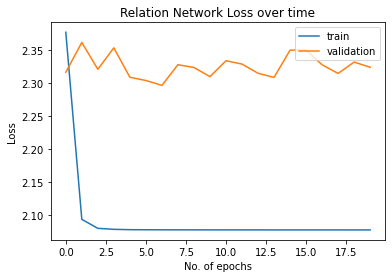

In [ ]:
plot_curve(train_loss_history, val_loss_history, title='Relation Network Loss over time', ylabel='Loss', legend_loc='upper right')

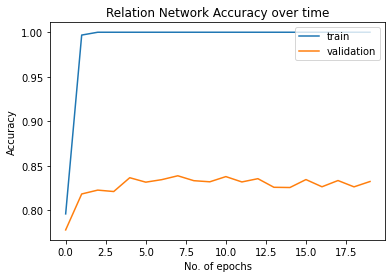

In [ ]:
plot_curve(train_acc_history, val_acc_history, title='Relation Network Accuracy over time', ylabel='Accuracy', legend_loc='upper right')

In [ ]:
df = pd.DataFrame(list(zip(train_acc_history, val_acc_history, train_loss_history, val_loss_history)),
               columns =['Train Accuracy', 'Val Accuracy', 'Train Loss', 'Val Loss'])
df 

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.796167,0.778167,2.376793,2.316419
1,0.996833,0.818500,2.094133,2.361317
2,1.000000,0.822833,2.080585,2.320836
3,1.000000,0.821250,2.079056,2.353242
4,1.000000,0.836750,2.078546,2.308776
5,1.000000,0.831750,2.078426,2.303915
6,1.000000,0.834583,2.078343,2.296500
7,1.000000,0.838917,2.078302,2.327765
8,1.000000,0.833417,2.078269,2.323551
9,1.000000,0.832167,2.078251,2.309730


In [ ]:
df.to_csv('drive/MyDrive/Flower_Recognition/experiment_name.csv')